## Import some helpful libraries

In [1]:
print("    Version control\n------------------------")
import os     # operating system interfaces
import fnmatch
import random
import datetime
import numpy as np;              print("Numpy\t\t", np.__version__)
import matplotlib as mpl;        print("matplotlib\t", mpl.__version__)
import matplotlib.pyplot as plt
import nibabel as nib;           print("NiBabel\t\t {}".format(nib.__version__))
from nibabel.testing import data_path
import math
import pandas as pd;             print("Pandas\t\t {}".format(pd.__version__))
import sys
import imageio;                  print("imageio\t\t {}".format(imageio.__version__))
import h5py;                     print("H5py\t\t {}".format(h5py.__version__))
import sklearn;                  print("Scikit-learn\t {}".format(sklearn.__version__))
import skimage;                  print("Scikit-image\t {}".format(skimage.__version__))
import tensorflow as tf;         print("TensorFlow\t {}".format(tf.__version__))
import keras as K;               print("Keras\t\t {}".format(K.__version__))
from tensorflow.keras import models, Input, Model
from tensorflow.keras.layers import Dense, Flatten, Reshape, BatchNormalization, Conv3D, MaxPooling3D, UpSampling3D
from tensorflow.keras.activations import relu, sigmoid
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from keras.callbacks import TensorBoard, EarlyStopping

    Version control
------------------------
Numpy		 1.19.4
matplotlib	 3.3.3
NiBabel		 3.2.0
Pandas		 1.1.4
imageio		 2.9.0
H5py		 2.10.0
Scikit-learn	 0.23.2
Scikit-image	 0.17.2
TensorFlow	 2.3.1
Keras		 2.3.1


Using TensorFlow backend.


## Loading Dataset: Training and Validation Datasets (randomly)

In [3]:
## Loading dataset from path directory
print(os.getcwd())     # '/Users/shossein/GitHub/DTI_Clustering'

## load train data
sample_train_subset = np.loadtxt("train_100_new_sample_name.csv", dtype=str, delimiter=",")
train_data = np.load('train_100_new.npy').reshape(100,182,218,182,1)
print('train_data shape is {}'.format(train_data.shape))

## load validation data
sample_val_subset = np.loadtxt("valid_24_new_sample_name.csv", dtype=str, delimiter=",")
valid_data = np.load('valid_24_new.npy').reshape(24,182,218,182,1)
print('valid_data shape is {}'.format(valid_data.shape))

/Users/shossein/GitHub/DTI_Clustering
train_data shape is (100, 182, 218, 182, 1)
valid_data shape is (24, 182, 218, 182, 1)


In [4]:
print("There are", len(sample_train_subset), " subset of train samples are:\n")
print(*sample_train_subset, sep='\t')
print("\n--------------------------------------------------------------------------------\n")
print("There are", len(sample_val_subset), " subset of Validation samples are:\n")
print(*sample_val_subset, sep='\t')

There are 100  subset of train samples are:

Pat_100_1-post.nii.gz	Pat_102_1-post.nii.gz	Pat_103_1-post.nii.gz	Pat_107_1-post.nii.gz	Pat_108_1-post.nii.gz	Pat_109_1-post.nii.gz	Pat_10_1-post.nii.gz	Pat_110_1-post.nii.gz	Pat_113_1-post.nii.gz	Pat_114_1-post.nii.gz	Pat_116_1-post.nii.gz	Pat_117_1-post.nii.gz	Pat_118_1-post.nii.gz	Pat_11_1-post.nii.gz	Pat_121_1-post.nii.gz	Pat_122_1-post.nii.gz	Pat_123_1-post.nii.gz	Pat_125_1-post.nii.gz	Pat_127_1-post.nii.gz	Pat_128_1-post.nii.gz	Pat_129_1-post.nii.gz	Pat_12_1-post.nii.gz	Pat_130_1-post.nii.gz	Pat_131_1-post.nii.gz	Pat_135_1-post.nii.gz	Pat_138_1-post.nii.gz	Pat_139_1-post.nii.gz	Pat_13_1-post.nii.gz	Pat_141_1-post.nii.gz	Pat_142_1-post.nii.gz	Pat_143_1-post.nii.gz	Pat_145_1-post.nii.gz	Pat_14_1-post.nii.gz	Pat_15_1-post.nii.gz	Pat_16_1-post.nii.gz	Pat_17_1-post.nii.gz	Pat_18_1-post.nii.gz	Pat_19_1-post.nii.gz	Pat_1_1-post.nii.gz	Pat_20_1-post.nii.gz	Pat_21_1-post.nii.gz	Pat_22_1-post.nii.gz	Pat_23_1-post.nii.gz	Pat_25_1-post.nii.gz	Pat_

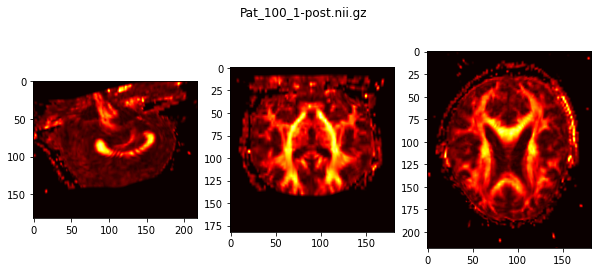

In [5]:
## Showing one or all Training samples in three dimension (one middle slice per each dimension)

def show_slices(slices):
    fig, axes = plt.subplots(1, len(slices), figsize=(10,5))
    for i, slice in enumerate(slices):
        axes[i].imshow(slice.T, cmap="hot", origin="upper") # hot, Greys, gray
        
# for m in range(train_data.shape[0]):
for m in range(1):
    slice_0 = train_data[m, 91, :, :, 0]
    slice_1 = train_data[m, :, 109, :, 0]
    slice_2 = train_data[m, :, :, 91, 0]
    show_slices([slice_0, slice_1, slice_2])
    plt.suptitle(sample_train_subset[m], x=0.5, y=0.9)

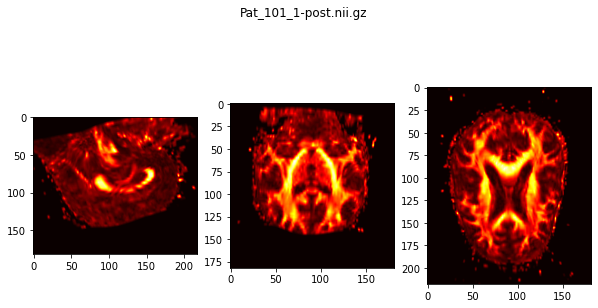

In [6]:
## Showing one or all Validation samples in three dimension (one middle slice per each dimension)

# for m in range(valid_data.shape[0]):
for m in range(1):
    slice_0 = valid_data[m, 91, :, :, 0]
    slice_1 = valid_data[m, :, 109, :, 0]
    slice_2 = valid_data[m, :, :, 91, 0]
    show_slices([slice_0, slice_1, slice_2])
    plt.suptitle(sample_val_subset[m], x=0.5, y=1)

## Model Design

In [7]:
## Define parameters:

IMAGE_HEIGHT = train_data.shape[1]
IMAGE_WIDTH = train_data.shape[2]
IMAGE_DEPTH = train_data.shape[3]
batch_size = 1
data_shape = [1, IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_DEPTH, 1]
input_shape = [batch_size, IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_DEPTH, 1]
print("input-layer shape:", input_shape)

## Encoder
input_img = Input(shape=(182, 218, 182, 1))
x = Conv3D(filters=64, kernel_size=3, strides=2, padding='same', activation='relu', name='Conv1')(input_img)
x = BatchNormalization()(x)
# x = MaxPooling3D(pool_size=(2, 2, 2), padding='valid')(x)

x = Conv3D(filters=32, kernel_size=3, strides=2, padding='same', activation='relu', name='Conv2')(x)
x = BatchNormalization()(x)
# x = MaxPooling3D(pool_size=(2, 2, 2), padding='valid')(x)

x = Conv3D(filters=16, kernel_size=3, strides=2, padding='same', activation='relu', name='Conv3')(x)
x = BatchNormalization()(x)
# x = MaxPooling3D(pool_size=(2, 2, 2), padding='valid')(x)

## Latent Features
# shape_before_flattening = tf.keras.backend.int_shape(x)
# x = Flatten()(x)
# init = VarianceScaling(scale=1. / 3., mode='fan_in', distribution='uniform')
## encoded = Dense(4, kernel_initializer=init, activation='relu', name='encoded')(x)
# encoded = Dense(4, activation='relu', name='encoded')(x)
# x = BatchNormalization()(encoded)
## x = Dense(np.prod(shape_before_flattening[1:]), activation='relu', kernel_initializer=init)(encoded)
# x = Dense(np.prod(shape_before_flattening[1:]), activation='relu')(encoded)
# x = Reshape(shape_before_flattening[1:])(x)

## Decoder
x = Conv3D(filters=32, kernel_size=3, padding='same', activation='relu', name='DeConv1')(x)
x = BatchNormalization()(x)
x = UpSampling3D(size=(2, 2, 2))(x)

x = Conv3D(filters=64, kernel_size=3, padding='same', activation='relu', name='DeConv2')(x)
x = BatchNormalization()(x)
x = UpSampling3D(size=(2, 2, 2))(x)

x = Conv3D(filters=128, kernel_size=(2,4,2), padding='valid', activation='relu', name='DeConv3')(x)
x = BatchNormalization()(x)
x = UpSampling3D(size=(2, 2, 2))(x)

decoded = Conv3D(filters=1, kernel_size=3, padding='same', activation='sigmoid', name='Output')(x)

model_CAE = Model(inputs=input_img, outputs=decoded)
## optimizer=rmsprop, sgd    loss=binary_crossentropy, SparseCategoricalCrossentropy(from_logits=False)
model_CAE.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
model_CAE.summary()

input-layer shape: [1, 182, 218, 182, 1]
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 182, 218, 182, 1) 0         
_________________________________________________________________
Conv1 (Conv3D)               (None, 91, 109, 91, 64)   1792      
_________________________________________________________________
batch_normalization (BatchNo (None, 91, 109, 91, 64)   256       
_________________________________________________________________
Conv2 (Conv3D)               (None, 46, 55, 46, 32)    55328     
_________________________________________________________________
batch_normalization_1 (Batch (None, 46, 55, 46, 32)    128       
_________________________________________________________________
Conv3 (Conv3D)               (None, 23, 28, 23, 16)    13840     
_________________________________________________________________
batch_normali

## Model Training

In [21]:
## Tensorboard

%load_ext tensorboard
# %reload_ext tensorboard
logdir = os.path.join("CAE_logs", datetime.datetime.now().strftime("%Y_%m_%d____%H_%M_%S"))
tb_callback = TensorBoard(logdir, histogram_freq=1)

In [ ]:
## Start time:
from datetime import datetime
start_time = datetime.now().strftime("%H:%M:%S")
print("\nStart Time =", start_time, "\n")

## Midel Fit
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=5, mode='auto')
model_CAE.fit(train_data, train_data, epochs=1, batch_size=batch_size, shuffle=True, validation_data=(valid_data, valid_data), callbacks=[tb_callback], verbose=1)
model_CAE.save_weights("CAE_weights.hdf5")
# autoencoder.load_weights("CAE_weights.hdf5")     # loading weights

# End time:
from datetime import datetime
end_time = datetime.now().strftime("%H:%M:%S")
print("\nEnd Time =", end_time)


Start Time = 02:58:56 

  1/100 [..............................] - ETA: 1s - loss: 0.2687 - accuracy: 0.1951WARNING:tensorflow:From /Users/shossein/anaconda3/envs/m36/lib/python3.6/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
 48/100 [=============>................] - ETA: 1:11:31 - loss: 0.0515 - accuracy: 0.6913

In [ ]:
tensorboard --logdir=CAE_logs       # http://localhost:6006/

In [8]:
model_CAE.load_weights("CAE_weights.hdf5")     # loading weights
test_data = train_data[0,:].reshape(1, 182, 218, 182, 1)
reconstructed = model_CAE.predict(test_data)

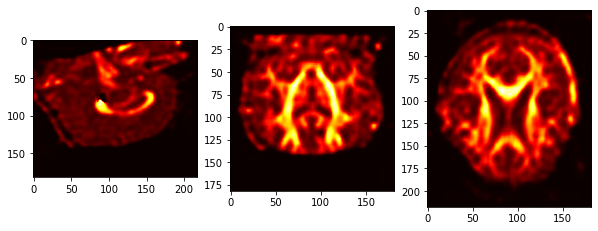

In [9]:
for m in range(1):
    slice_0 = reconstructed[m, 91, :, :, 0]
    slice_1 = reconstructed[m, :, 109, :, 0]
    slice_2 = reconstructed[m, :, :, 91, 0]
    show_slices([slice_0, slice_1, slice_2])

In [10]:
print('\ntrain_data[0,100,100:105,100]\n\n {}'.format(train_data[0,100,100:105,100]),'\n')
print('\nReconstructed_data[0,100,100:105,100]\n\n {}'.format(reconstructed[0,100,100:105,100]),'\n')


train_data[0,100,100:105,100]

 [[0.55211586]
 [0.51723999]
 [0.52700305]
 [0.62761533]
 [0.59050184]] 


Reconstructed_data[0,100,100:105,100]

 [[0.56365746]
 [0.5883272 ]
 [0.58999026]
 [0.5933921 ]
 [0.56913716]] 



In [12]:
h5_file = h5py.File('CAE_weights.hdf5', 'r')
print(list(h5_file.keys()))
# for L in (list(h5_file.keys())):
#     print(L)
#     L = h5_file[layer]
#     W = L[layer]['kernel:0']
#     print(W.shape)

L = h5_file[list(h5_file.keys())[0]]
W = L[list(h5_file.keys())[0]]['kernel:0']
print('\nWeiths shape: {}'.format(W.shape))
print('\nWeights[2][2][2]: {}'.format(W[2][2][2]))

['Conv1', 'Conv2', 'Conv3', 'DeConv1', 'DeConv2', 'DeConv3', 'Output', 'batch_normalization', 'batch_normalization_1', 'batch_normalization_2', 'batch_normalization_3', 'batch_normalization_4', 'batch_normalization_5', 'input_1', 'up_sampling3d', 'up_sampling3d_1', 'up_sampling3d_2']

Weiths shape: (3, 3, 3, 1, 64)

Weights[2][2][2]: [[-0.04527123 -0.05361699 -0.0375476   0.03983468  0.05198799  0.01336781
   0.02545989  0.01477338  0.03302819 -0.03856006  0.0162205  -0.00210137
   0.01809318 -0.0043942  -0.01803821 -0.00989678 -0.03573933 -0.05639834
  -0.0699588  -0.0134985   0.03655147  0.02561177  0.00836402  0.03665265
   0.05702159  0.01731635 -0.04967237 -0.03273723  0.00217982  0.00226386
   0.04743922 -0.02777269  0.01819022  0.05790557  0.00843741  0.03987621
  -0.02167159 -0.05570199  0.05099694 -0.05183971 -0.01941423 -0.10505915
  -0.01848529 -0.02346312 -0.01297883  0.05645465 -0.04227443 -0.00991715
   0.00518689  0.01872476  0.03509067 -0.04219169 -0.05524024 -0.0288775